---
title: "Matrix Factorization for Recommender Systems"
author: "chris"
date: 2024-01-25
draft: false
---

It's pretty difficult to escape recommender systems in 2024.  These days, we regularly get recommended things such as content from streaming services like Netflix and products from online shopping platforms like Amazon.  Even if you don't know the term recommender systems, there's a good chance you understand what it does.

I first heard about recommender systems in the context of the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) which was an open competition in 2009 for best collaborative filtering (CF) algorithm.  The challenge was to improve upon Netflix's existing recommender system by at least `0.10 RMSE` and the winner was awarded $1MM.  Around that time, [nearest neighbor techniques were popular](https://arxiv.org/abs/2209.01860) CF methods however, the winners of the Netflix prize proved that [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization) (MF) models were superior.  MF models have some similarity to singular value decomposition (SVD) but can handle sparsity often seen with recommender system datasets whereas SVD can't.

To understand more about MF and recommender systems, in this post I'll be creating an algorithm from scratch and evaluating it's performance on the [MovieLens 20M dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset) (see [here](https://grouplens.org/datasets/movielens/20m/) for more info).  In particular, I'll be implementing probabilistic matrix factorization (PMF) which was a seminal improvement over previous MF techniques because of it's ability to handle sparsity and scale linearly with data ([see paper here](https://proceedings.neurips.cc/paper_files/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf)).



### Intuition

Before diving into a mathematical derivation, let me provide some intuition about how MF works.

In a ratings scenario we have some number of `n` users and `m` movies.  This can be represented with an `n x m` matrix where values of the matrix are the ranking a person gave to a movie.  For simplicity, let's say the value is a 1 if they watched and liked the movie otherwise it's a 0.  Most people will only watch a handful of movies so there'll be many missing values in the matrix.

In the ratings matrix, each user can be described by the sparse vector of 1's (mostly 0's) that indicate the movies they liked (or the users that liked them in the case of movie vectors).  But we can use a more compact representation similar to how one-hot encoded words are condensed via word embeddings.  This allows for better comparison if we want to use something like cosine similarity to compare users, for example.

The dense representations of users and movies will form two smaller matrices, an `n x d` user matrix and an `m x d` movie matrix where `d << n` and `d << m`.  You can see from a quick dimensionality analysis that the product of these two smaller matrices could be an approximation for the original ratings matrix.  In fact, we could minimize the difference between the approximation and the true rating in an optimization process.  Once we've done that, we would even have an estimate of the rating a user might have given a movie even if they didn't watch it.  And the movie with the highest likelihood of a positive rating, well we can recommend that to a user.  So at a high level, that's exactly what I'm going to do here with MF.

### MAP and Objective Function

Time for more formal mathematical definitions.  Like I mentioned above, we have $n$ users and $m$ movies as well as a ratings matrix $R \in \mathbb{R}^{n \times m}$ such that $R_{i,j}$ is the rating by user $i$ for movie $j$.  The user latent matrix is $U \in \mathbb{R}^{d \times n}$ and movie latent matrix $V \in \mathbb{R}^{d \times m}$ where $d$ is the latent space dimension and a tunable hyperparameter.

The author's of the paper make an assumption on the distribution of $R_{i,j}$, which is the product of latent vectors $U_i$ and $V_j$.

$$R_{i,j} \sim N(U_i^{\intercal} V_j, \sigma ^ 2)$$

And the latent vectors $U_i$ and $V_j$ are also assumed to be normally distributed with zero mean and spherical covariance (dimensionality $d$).  You don't always hear this term "spherical covariance" but it essentially means all dimensions are independent with same mean and variance (i.e. IID).  The variance is also tunable via the $\lambda$ parameter (defined further below).

$$U_i \sim N(0, \sigma_u ^ 2 \mathbf{I})$$

$$V_j \sim N(0, \sigma_v ^ 2 \mathbf{I})$$

Now we can define the likelihood function for the entire ratings matrix

$$
p(R|U,V,\sigma^2) = \prod\limits_{i}^{n}\prod\limits_{j}^{m} p(R_{i,j} | U_i, V_j)
$$

as well as prior probabilities on the latent matrices.

$$
p(U|\sigma_u^2) = \prod\limits_{i}^{n} p(U_i) \; , \quad p(V|\sigma_v^2) = \prod\limits_j^m p(V_i)
$$

In [a previous post](https://cbhyphen.github.io/posts/gaussian-bayes-classifier/gaussian_bayes_classifier.html#maximum-a-posteriori) I went through a process to derive a MAP estimate.  This is similar.  Here we can also approximate the posterior by the product of the likelihood and priors

$$
p(U,V|R,\sigma^2, \sigma_u^2, \sigma_v^2) ≈ p(R|U,V,\sigma^2) \cdot p(U|\sigma_u^2) \cdot p(V|\sigma_v^2)
$$

and because summations are easier to work with than products, we take the log of the posterior (see paper for details) and maximize that to derive the MAP solution.  After some re-arranging for a minimization objective, we would arrive at the following objective function as described in the paper.

$$
E = \frac{1}{2} \sum_i^n \sum_j^m I_{i,j}(R_{i,j} - U_i^\intercal V_j)^2 + \frac{\lambda_u}{2} \sum_i^n \Vert U_i \Vert ^ 2 +  \frac{\lambda_v}{2} \sum_j^m \Vert V_j \Vert ^ 2
$$

where $I_{i,j}$ is an indicator function if user $i$ has rated movie $j$, and $\lambda_u = \frac{\sigma^2}{\sigma_u^2}$ and similarly $\lambda_v = \frac{\sigma^2}{\sigma_v^2}$.  The indicator function is an important addition in the objective function as it allows us to ignore the vast number of unrated movies for each user.  

An interesting aside here is that the priors are essentially adding L2 regularization terms in the objective function.  If we were to maximize the likelihood only (i.e. MLE) we wouldn't have these terms.

Ok, so the paper gets us to this objective function but leaves out any description of a learning algorithm.  So now we have to derive update rules in order to learn values for $U$ and $V$.

### Derivation of Learning Algorithm

If you look at the objective function, you'll see we have two unknown latent matrices $U$ and $V$.  Because of this, the objective function is not convex.  However, if one of the matrices is fixed, then the other turns into a convex optimization problem.  So we can take turns with updates to $U$ and $V$ by performing an alternating coordinate descent.  Note that in this context it is also referred to least squares optimization (ALS).  These links by [Facebook](https://engineering.fb.com/2015/06/02/core-infra/recommending-items-to-more-than-a-billion-people/) and [Google](https://developers.google.com/machine-learning/recommendation/collaborative/matrix) were helpful for confirming this important optimization detail.

To find the update rules, we need to derive partial derivatives for $U_i$ and $V_j$ with respect to the objective function.  So, time to dive into a little matrix calculus with a derivation for $\frac{\partial E}{\partial U_i}$.

$$
\frac{\partial E}{\partial U_i} = \frac{\partial}{\partial U_i} \biggl[ \frac{1}{2}\sum_i^n \sum_j^m I_{i,j}(R_{i,j} - U_i^\intercal V_j)^2 \biggr] + \frac{\partial}{\partial U_i} \biggl[ \frac{\lambda_u}{2} \sum_i^n \Vert U_i \Vert ^ 2 \biggr] + \frac{\partial}{\partial U_i} \biggl[ \frac{\lambda_v}{2} \sum_j^m \Vert V_j \Vert ^ 2 \biggr]
$$

$$
\frac{\partial E}{\partial U_i} = \frac{1}{2}\sum_i^n \sum_j^m I_{i,j} \frac{\partial}{\partial U_i} \biggl[ (R_{i,j} - U_i^\intercal V_j)^2 \biggr] + \frac{\lambda_u}{2} \sum_i^n \frac{\partial}{\partial U_i} \biggl[ \Vert U_i \Vert ^ 2 \biggr]
$$

Summation over $i$ dissappears as there is only one term that is not a constant when differentiating with respect to $U_i$.

$$
\frac{\partial E}{\partial U_i} = \lambda_u U_i - \sum_j^m I_{i,j}(R_{i,j} - U_i^\intercal V_j) V_j
$$

Now we can solve for this in closed form by setting the gradient to zero which gives direct update rules (gradient descent isn't necessary).

$$
\lambda_u U_i - \sum_j^m I_{i,j}(R_{i,j} - U_i^\intercal V_j) V_j = 0
$$

$$
\lambda_u U_i - \sum_j^m I_{i,j} R_{i,j} V_j + U_i \sum_j^m I_{i,j} V_j V_j^\intercal = 0
$$

And solving for $U_i$ we have

$$
U_i \biggl( \lambda_u \mathbf{I} + \sum_j^m I_{i,j} V_j V_j^\intercal \biggr) = \sum_j^m I_{i,j} R_{i,j} V_j
$$

$$
U_i = \sum_j^m I_{i,j} R_{i,j} V_j \biggl( \lambda_u \mathbf{I} + \sum_j^m I_{i,j} V_j V_j^\intercal \biggr)^{-1}
$$

and it follows similarly for $V_j$

$$
V_j = \sum_i^n I_{i,j} R_{i,j} U_i \biggl(\lambda_v \mathbf{I} + \sum_i^n I_{i,j} U_i U_i^\intercal \biggr)^{-1}
$$

There is another interesting aside here about the priors.  If we were to do MLE instead of MAP we'd get a similar update rule except for the $\lambda_v \mathbf{I}$ term.  If you've ever tried to implement your own [least squares solution](https://en.wikipedia.org/wiki/Ordinary_least_squares#Matrix/vector_formulation) in closed form, you may remember that regression coefficients require inverting the matrix $(X^\intercal X)^{-1}$.  Sometimes your data doesn't behave well and you end up with a non-invertible matrix (because your determinant is zero).  The  $\lambda_v \mathbf{I}$ term is essentially adding some values to the diagonal of the matrix which makes it less likely to have a zero determinant (i.e. more stable).

Ok, so armed with these update rules now we can dive into some code.


### Code

In [ ]:
# !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!wget https://files.grouplens.org/datasets/movielens/ml-10m.zip

# https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html
# https://files.grouplens.org/datasets/movielens/ml-10m-README.html

--2024-02-14 04:07:27--  https://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M  22.4MB/s    in 2.8s    

2024-02-14 04:07:31 (22.4 MB/s) - ‘ml-10m.zip’ saved [65566137/65566137]



In [ ]:
# !unzip ml-latest-small.zip -d ./
!unzip ml-10m.zip -d ./

Archive:  ml-10m.zip
   creating: ./ml-10M100K/
  inflating: ./ml-10M100K/allbut.pl  
  inflating: ./ml-10M100K/movies.dat  
  inflating: ./ml-10M100K/ratings.dat  
  inflating: ./ml-10M100K/README.html  
  inflating: ./ml-10M100K/split_ratings.sh  
  inflating: ./ml-10M100K/tags.dat   


In [ ]:
import pandas as pd

# ratings_df = pd.read_csv("./ml-latest-small/ratings.csv")
ratings_df = pd.read_csv(
    "./ml-10M100K/ratings.dat",
    sep="::",
    header=None,
    names=["userId", "movieId", "rating", "timestamp"]
)
print(ratings_df.shape)
ratings_df.head()

<ipython-input-18-2cb4649a6a86>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_csv(


(10000054, 4)


,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [ ]:
# ratings are in increments of 0.5
ratings_df.rating.value_counts()

4.0    2875850
3.0    2356676
5.0    1544812
3.5     879764
2.0     790306
4.5     585022
1.0     384180
2.5     370178
1.5     118278
0.5      94988
Name: rating, dtype: int64

In [ ]:
# remove timestamp and create ratings matrix
ratings_df.drop("timestamp", axis=1, inplace=True)
R = ratings_df.pivot(index='userId', columns='movieId', values='rating')
print(R.shape)
R.head()

(69878, 10677)


movieId,1,2,3,4,5,6,7,8,9,10,...,65006,65011,65025,65027,65037,65088,65091,65126,65130,65133
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np

R = R.to_numpy()

In [ ]:
# sanity check - all movies have rating and all users have rated as expected
users_not_rated = np.all(np.isnan(R), axis=1).sum()
movies_not_rated = np.all(np.isnan(R), axis=0).sum()
assert 0 == users_not_rated == movies_not_rated

In [ ]:
# ratio missing values
n, m = R.shape
nans = np.isnan(R).sum()
num_ratings = m * n - nans

print(f"total number of users: {n}")
print(f"total number of movies: {m}")
print(f"total number of movie ratings: {num_ratings}")
print(f"total number of possible ratings: {n * m}")
print(f"missing values in ratings matrix: {100 * round(nans / (m * n), 3)}%")

total number of users: 69878
total number of movies: 10677
total number of movie ratings: 10000054
total number of possible ratings: 746087406
missing values in ratings matrix: 98.7%


In [ ]:
# indices of ratings
rating_idxs = np.argwhere(np.isfinite(R))  # 2D array [[i ,j], ...]

# randomly select 15% of rating indices to keep as test
train_slice = np.random.choice(num_ratings, size=int(num_ratings * 0.85), replace=False)
test_slice = np.setdiff1d(np.arange(num_ratings), train_slice)

train_idxs = rating_idxs[train_slice, :]
test_idxs = rating_idxs[test_slice, :]

train_idxs.shape, test_idxs.shape

((8500045, 2), (1500009, 2))

In [ ]:
# fill test indices with nan in training data
R_train = R.copy()

for i, j in test_idxs:
    R_train[i, j] = np.nan

assert np.isnan(R_train).sum() == nans + test_idxs.shape[0]

In [ ]:
# normalizing the training data to zero mean and sigma of 1 for simplicity
ii_train = train_idxs[:, 0].flatten()
jj_train = train_idxs[:, 1].flatten()

R_train_mu = R_train[ii_train, jj_train].mean()
R_train_sigma = R_train[ii_train, jj_train].std()
R_train = (R_train - R_train_mu) / R_train_sigma

print(f"R train mu: {round(R_train_mu, 2)}\t R train sigma: {round(R_train_sigma, 2)}")

R train mu: 3.51	 R train sigma: 1.06


In [ ]:
# paper uses:
#  d=30 with original netflix dataset 100M+ ratings, ~500k users, ~20k movies
#  adaptive prior w/ spherical covariances lambda U = 0.01, lambda V = 0.001
#  constrained PMF lambda = 0.002
d = 30
lambda_u = 20  # higher better, just some random experimentation here
lambda_v = 20
sigma_r = 1  # np.std(R[~np.isnan(R)])
sigma_u = np.sqrt(sigma_r**2 / lambda_u)  # assume sigma=1 for ratings matrix
sigma_v = np.sqrt(sigma_r**2 / lambda_v)

# randomly generate values for user and movie latent matrices
# U can be empty since updated first
U_mu = np.zeros(d)
U_cov = np.identity(d) * sigma_u**2  # spherical
U = np.random.multivariate_normal(U_mu, U_cov, size=n).T

V_mu = np.zeros(d)
V_cov = np.identity(d) * sigma_v**2
V = np.random.multivariate_normal(V_mu, V_cov, size=m).T

# D x M/N
U.shape, V.shape

((30, 69878), (30, 10677))

In [ ]:
# function to update U_i latent vector

def update_U_i(i, ratings_matrix, user_matrix, movie_matrix, lambda_u):
    # valid j (i.e. movies this user rated)
    j_idxs = np.argwhere(np.isfinite(ratings_matrix[i, :])).flatten()
    # skip if no movies rated in train set
    if len(j_idxs) == 0:
        return
    # running summation
    sum_rv = np.zeros(d)  # vector: weighted V_j by R_ij
    sum_vv = np.zeros((d, d))  # matrix: outer product V_j
    for j in j_idxs:
        V_j = movie_matrix[:, j]
        sum_rv += V_j * ratings_matrix[i, j]
        sum_vv += np.outer(V_j, V_j)
    user_matrix[:, i] = sum_rv @ np.linalg.inv(sum_vv + np.identity(d) * lambda_u)


def update_V_j(j, ratings_matrix, user_matrix, movie_matrix, lambda_v):
    # valid i (i.e. users that rated this movie)
    i_idxs = np.argwhere(np.isfinite(ratings_matrix[:, j])).flatten()
    # skip if no users rated in train set
    if len(i_idxs) == 0:
        return
    sum_ru = np.zeros(d)  # vector: weighted U_i by R_ij
    sum_uu = np.zeros((d, d))  # matrix: outer product U_i
    for i in i_idxs:
        U_i = user_matrix[:, i]
        sum_ru += U_i * ratings_matrix[i, j]
        sum_uu += np.outer(U_i, U_i)
    movie_matrix[:, j] = sum_ru @ np.linalg.inv(sum_uu + np.identity(d) * lambda_v)


In [ ]:
# use logistic function since ratings prediction is zero mean (same as paper)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# map sigmoid to range [1, 5] (same as paper)
# there are 0.5 ratings so this isn't perfect

def sigmoid_to_rating(x, k=5):
    return (k - 1) * x + 1


In [ ]:
# run optimization and report RMSE

epochs = 20
train_rmse = []
valid_rmse = []

# lambda_u_hat = lambda_u
# lambda_v_hat = lambda_v

for e in range(epochs):

    for i in range(n):
        update_U_i(i, R_train, U, V, lambda_u)

    for j in range(m):
        update_V_j(j, R_train, U, V, lambda_v)

    # adaptive...  single sigma -> update lambda_uv = 1 / (sigma_uv ** 2)
    # if (e + 1) % 10 == 0:
    #     sigma_u_hat = np.std(U, axis=1)
    #     sigma_v_hat = np.std(V, axis=1)
    #     lambda_u_hat = 1 / (sigma_u_hat ** 2)
    #     lambda_v_hat = 1 / (sigma_v_hat ** 2)
    # print(f"sigma U: {sigma_u_hat}")
    # print(f"sigma V: {sigma_v_hat}")
    # print(f"lambda u: {lambda_u_hat}")
    # print(f"lambda v: {lambda_v_hat}")

    # training metrics
    sse = 0
    sse_norm = 0
    for i, j in train_idxs:  # skips NA
        r_ij_hat = np.dot(U[:, i], V[:, j])  # pred
        rating = sigmoid_to_rating(sigmoid(r_ij_hat))
        # rating_half_inc = round(rating * 2) / 2  # rounds to nearest 0.5
        sse += (R[i, j] - rating) ** 2
        sse_norm += (R_train[i, j] - r_ij_hat) ** 2
    rmse_train = np.sqrt(sse / train_idxs.shape[0])
    rmse_norm = np.sqrt(sse_norm / train_idxs.shape[0])
    print(f"epoch {e + 1}  |  training RMSE: {round(rmse_train, 4)} (normalized: {round(rmse_norm, 4)})")
    train_rmse.append(rmse_train)

    # validation RMSE
    sse = 0
    for i, j in test_idxs:
        r_ij_hat = np.dot(U[:, i], V[:, j])
        rating = sigmoid_to_rating(sigmoid(r_ij_hat))
        # rating_half_inc = round(rating * 2) / 2  # rounds to nearest 0.5
        sse += (R[i, j] - rating) ** 2
    rmse_valid = np.sqrt(sse / test_idxs.shape[0])
    print(f"epoch {e + 1}  |  validation RMSE: {round(rmse_valid, 4)}")
    valid_rmse.append(rmse_valid)


epoch 1  |  training RMSE: 1.0294 (normalized: 0.8594)
epoch 1  |  validation RMSE: 1.1035
epoch 2  |  training RMSE: 0.8958 (normalized: 0.6913)
epoch 2  |  validation RMSE: 0.9757
epoch 3  |  training RMSE: 0.8798 (normalized: 0.6679)
epoch 3  |  validation RMSE: 0.9624
epoch 4  |  training RMSE: 0.8735 (normalized: 0.6588)
epoch 4  |  validation RMSE: 0.9573
epoch 5  |  training RMSE: 0.8704 (normalized: 0.6542)
epoch 5  |  validation RMSE: 0.9546
epoch 6  |  training RMSE: 0.8685 (normalized: 0.6515)
epoch 6  |  validation RMSE: 0.9529
epoch 7  |  training RMSE: 0.8672 (normalized: 0.6498)
epoch 7  |  validation RMSE: 0.9517
epoch 8  |  training RMSE: 0.8663 (normalized: 0.6486)
epoch 8  |  validation RMSE: 0.9508
epoch 9  |  training RMSE: 0.8657 (normalized: 0.6477)
epoch 9  |  validation RMSE: 0.9501
epoch 10  |  training RMSE: 0.8652 (normalized: 0.6471)
epoch 10  |  validation RMSE: 0.9496
epoch 11  |  training RMSE: 0.8648 (normalized: 0.6466)
epoch 11  |  validation RMSE: 0.

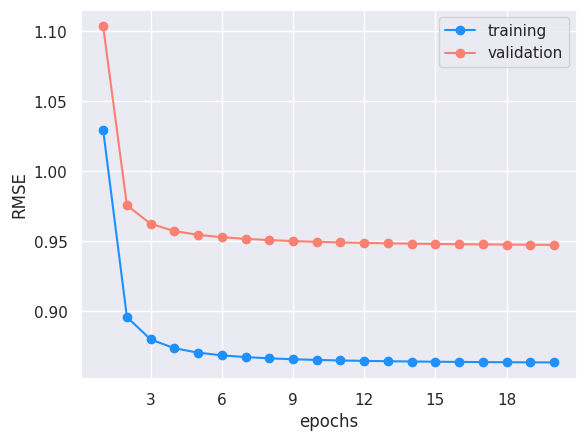

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sns.set()
iterations = np.arange(1, epochs + 1, 1)

ax = plt.figure().gca()
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.plot(iterations, train_rmse, "-o", color="dodgerblue", label="training")
plt.plot(iterations, valid_rmse, "-o", color="salmon", label="validation")
plt.legend(loc="best")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


The baseline RMSE that Netflix had achieved before the competition was `0.95`.  This beats that by a small margin but the dataset is different so it's not an apples to apples comparison.  Also, the range of ratings goes down to `0.5` in the MovieLens dataset whereas prediction mapping was consistent with the paper and Netflix dataset which had a range of `[1, 5]`.  This was mostly an exercise in understanding PMF and implementing an algorithm based off an objective function in a research paper.  But, if we wanted to squeeze out more performance there are several things we could do:

- map predictions to `[0.5, 5]`
- use adaptive covariance (biggest gains)
- tune the lambda regularization coefficients (I started with `1` and only went up/down by an order of magnitude)
- separate covariances for users and movies
- diagonal covariance matrix (instead of spherical) to account for different variation between latent features